### 背景
来源百度百科：

#### 【什么是滑脱】

腰椎滑脱 是由于先天性发育不良、创伤、劳损等原因造成相邻椎体骨性连接异常而发生的上位椎体与下位椎体部分或全部滑移，表现为腰骶部疼痛、坐骨神经受累、间歇性跛行等症状的疾病。

在所有的腰椎滑脱中，由峡部崩裂引起的滑脱约占15%，退行性腰椎滑脱约占35%。在我国腰椎滑脱的发病年龄多在20~50岁，占85%；男性明显多于女性，男女之比为 29：1。腰椎滑脱最常见的部位是 L4~L5 及 L5~S1，其中腰5椎体发生率为82~90% 。滑脱的椎体可引起或加重椎管狭窄，刺激或挤压神经，引起腰痛、下肢痛、下肢麻木、甚至大小便功能障碍等症状。另外，滑脱后腰背肌的保护性收缩可引起腰背肌劳损，产生腰背痛。

可以通过X光检查、CT检查、MR检查进行诊断。以腰椎的侧位方向观察为佳。

#### 【滑脱的分级】

国内常用的是 Meyerding 分级，即将下位椎体上缘分为 4 等份，根据椎体相对下位椎 体向前滑移的程度分为 I－IV 度。(如下图)

Ⅰ：指椎体向前滑动不超过椎体中部矢状径的 1/4 者。

Ⅱ ：超过 1/4，但不超过 2/4 者。

Ⅲ ：超过 2/4，但不超过 3/4 者。

Ⅳ ：超过椎体矢状径的 3/4 者。
 
#### 【项目的目的】

腰椎的MR检查是一种无创检查。对腰椎的软组织、椎间盘、脊髓等组织的观察有优势。目前想通过腰椎MR检查的图像结合人工智能进行多种腰椎疾病辅助诊断，减少医生的负担。因为腰椎滑脱是一种常见的腰椎疾病，所有这个项目通过分割来解决腰椎滑脱分级这个问题。
![](https://ai-studio-static-online.cdn.bcebos.com/136bda7fb27e4f70a64aef1229ce60f0c65b286b28fe48abad8e47c495e84de0)

#### 【项目最终分级结果】

推理过程是基于诊断腰椎滑脱Meyerding标准。推理结果基本是符合腰椎滑脱的影像诊断要求。

![](https://ai-studio-static-online.cdn.bcebos.com/b5503152df254138963c9478e5046c36172696a0b23a4be4974f306793302194)




In [ ]:
#解压数据集
!cd /home/aistudio/
!unzip -o data/data101103/spine.zip -d work/

In [1]:
#安装paddleseg
!pip install  paddleseg

In [ ]:
#生成搭建DataSet所需要的train.txt 和val.txt
import os
dataset_path = '/home/aistudio/work'
origin_path = os.path.join( '/home/aistudio/work/MRJPG')
label_path = os.path.join( '/home/aistudio/work/NewMaskPNG')
with open(os.path.join(dataset_path, 'train_list.txt'), 'w') as train_file:
    with open(os.path.join(dataset_path, 'val_list.txt'), 'w') as val_file:
        for idx, pic_name in enumerate(os.listdir(origin_path)):
            img_path = os.path.join(origin_path, pic_name)
            mask_path = os.path.join(label_path, pic_name.replace('jpg','png'))
            if idx % 7 == 0:
                val_file.write(img_path + ' ' + mask_path + '\n')
            else:
                train_file.write(img_path + ' ' + mask_path + '\n')

### 创建DataSet

In [ ]:
from paddleseg.datasets import Dataset
import paddleseg.transforms as T

train_transform = [
    T.RandomRotation(max_rotation=10,im_padding_value  = ( 0,0,0 ),label_padding_value  =  0 ),
    T.Resize(target_size=(752, 752)),
    T.RandomHorizontalFlip(),
    T.RandomDistort(brightness_range = 0.4,contrast_range = 0.4,saturation_prob = 0,hue_prob = 0),
    T.RandomBlur(prob = 0.2),
    T.Normalize()
]
val_transform = [
    T.Resize(target_size=(752, 752)),
    T.Normalize()
]

train_data = Dataset(
    transforms=train_transform,
    dataset_root='/home/aistudio/work',
    num_classes=20,
    mode='train',
    train_path='/home/aistudio/work/train_list.txt',
)
val_data = Dataset(
    transforms=val_transform,
    dataset_root='/home/aistudio/work',
    num_classes=20,
    mode='val',
    val_path='/home/aistudio/work/val_list.txt',
)

In [ ]:
from paddleseg.models import OhemCrossEntropyLoss
import paddle
from paddleseg.core import train

from paddleseg.models import BiSeNetV2
model = BiSeNetV2(num_classes=20,
                 lambd=0.25,
                 align_corners=False,
                 pretrained='/home/aistudio/BiSetNetV2model.pdparams'
                 )
iters = 13000
batch_size = 8
scheduler =paddle.optimizer.lr.PolynomialDecay(learning_rate=0.02, decay_steps=iters,power =0.9, end_lr=0.0,verbose=False)
optimizer= paddle.optimizer.Momentum(learning_rate=scheduler, parameters=model.parameters())
losses = {}
losses['types'] = [OhemCrossEntropyLoss()] * 5
losses['coef'] = [1]* 5

train(
    model=model,
    train_dataset=train_data,
    val_dataset=val_data,
    optimizer=optimizer,
    save_dir='BiSeNetoutput2',
    iters=iters,
    batch_size=batch_size,
    save_interval=91,
    log_iters=20,
    num_workers=0,
    losses=losses,
    use_vdl=True,
)

### 预览经过数据增强后的数据
此项目数据使用[第二届CSIG图像图形技术挑战赛——磁共振图像脊柱结构多类别三维自动分割](https://www.spinesegmentation-challenge.com/)的比赛数据。
只保留每个腰椎数据中的中间几层。并把横突、棘突、骶骨(只保留骶一）和尾骨的标签去掉。然后原始数据保存成jpg格式，标签数据保存成png格式。
![](https://ai-studio-static-online.cdn.bcebos.com/66c2692ccb1c4b4cadd61cadd2ab1f245e3945ecc97c46a6927594a0985fdd46)



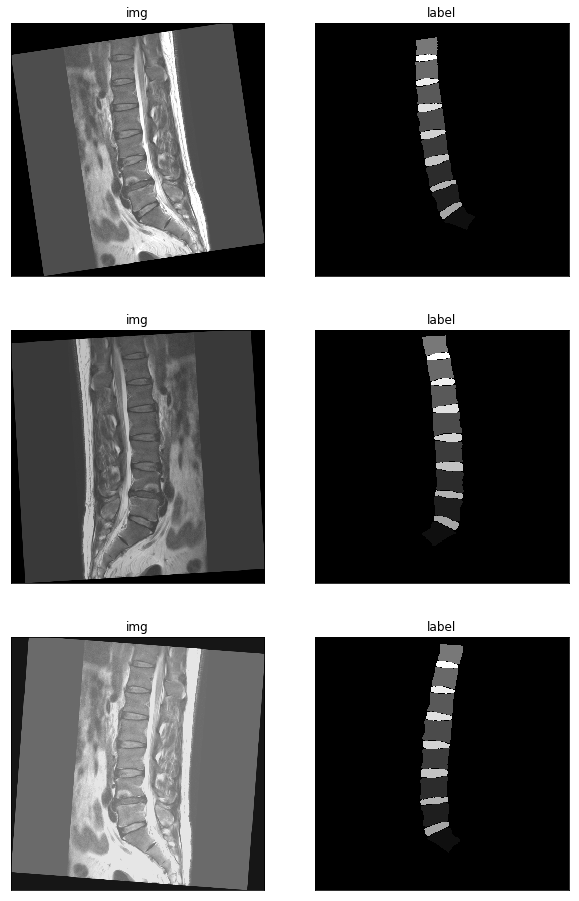

In [ ]:
#预览经过数据增强后的数据
#没有显示 ，在运行一次
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10,16))
for i in range(1,6,2):
    img, label = train_data[51]
    img = np.transpose(img, (1,2,0))
    img = img*0.5 + 0.5
    plt.subplot(3,2,i),plt.imshow(img,'gray'),plt.title('img'),plt.xticks([]),plt.yticks([])
    plt.subplot(3,2,i+1),plt.imshow(label,'gray'),plt.title('label'),plt.xticks([]),plt.yticks([])
    plt.show

### 搭建网络并训练
这次项目使用的是SFNet语义分割网络

In [ ]:
import paddle
from paddleseg.models import ResNet50_vd,SFNet
from paddleseg.models import OhemCrossEntropyLoss

url = 'https://bj.bcebos.com/paddleseg/dygraph/resnet50_vd_ssld_v2.tar.gz'
model = SFNet(
    num_classes=20, 
    backbone=ResNet50_vd(output_stride=8),
    backbone_indices=[0, 1, 2, 3],
    pretrained=url
)


In [ ]:

iters = 15000
batch_size = 4
scheduler =paddle.optimizer.lr.PolynomialDecay(learning_rate=0.02, decay_steps=iters,power =0.9, end_lr=0.0,verbose=False)
optimizer= paddle.optimizer.Momentum(learning_rate=scheduler, parameters=model.parameters())
losses = {}
losses['types'] = [OhemCrossEntropyLoss()]
losses['coef'] = [1]

In [ ]:
from paddleseg.core import train

train(
    model=model,
    train_dataset=train_data,
    val_dataset=val_data,
    optimizer=optimizer,
    save_dir='output',
    iters=iters,
    batch_size=batch_size,
    save_interval=182,
    log_iters=20,
    num_workers=0,
    losses=losses,
    use_vdl=True,
)

In [ ]:
#SFnet 评估
from paddleseg.core import evaluate
evaluate(
        model, 
        val_data, 
)

### 模型评估结果
骶一 、腰5、腰4、腰3、腰2、腰1、胸12、胸11、胸10的MIOU分别是

0.9051 0.9236 0.9292 0.9314 0.9343 0.9372 0.9306 0.9166 0.8615
```
2021-07-21 21:56:57 [INFO]	[EVAL] #Images: 122 mIoU: 0.8868 Acc: 0.9929 Kappa: 0.9541 
2021-07-21 21:56:57 [INFO]	[EVAL] Class IoU: 
[0.9929 0.9051 0.9236 0.9292 0.9314 0.9343 0.9372 0.9306 0.9166 0.8615
 0.8986 0.8413 0.8522 0.8828 0.8681 0.8801 0.8815 0.853  0.805  0.7103]
2021-07-21 21:56:57 [INFO]	[EVAL] Class Acc: 
[0.9963 0.9565 0.9582 0.9653 0.9684 0.9658 0.9649 0.9661 0.9565 0.929
 0.9149 0.9015 0.9195 0.9412 0.9475 0.9398 0.9382 0.925  0.8888 0.8345]
```

### 模型推理预览结果

2021-07-22 12:18:16 [INFO]	No pretrained model to load, ResNet_vd will be trained from scratch.


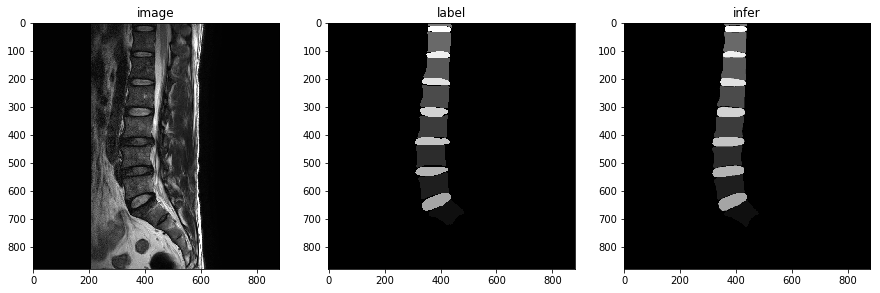

In [ ]:

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import paddle
import paddleseg.transforms as T
from paddleseg.core import infer
from paddleseg.models import ResNet50_vd,SFNet

#nn_infer 是geoyee狗子分割项目中的推理代码
def nn_infer(model, img_path, model_path):
    # 网络定义
    para_state_dict = paddle.load(model_path)
    model.set_dict(para_state_dict)
    # 预测结果
    transforms = T.Compose([
    T.Resize(target_size=(752, 752)),
    T.Normalize()
        ])
    img, _ = transforms(img_path)
    img = paddle.to_tensor(img[np.newaxis, :])
    pre = infer.inference(model, img)
    pred = paddle.argmax(pre, axis=1).numpy().reshape((752, 752))
    return pred.astype('uint8')

params = 'output2/best_model/model.pdparams'
model = SFNet(
    num_classes=20, 
    backbone=ResNet50_vd(output_stride=8),
    backbone_indices=[0, 1, 2, 3],
)
img_path = '/home/aistudio/work/MRJPG/764.jpg'
lab_path = '/home/aistudio/work/NewMaskPNG/764.png'

img = np.asarray(Image.open(img_path))
lab = np.asarray(Image.open(lab_path))
# 还原大小
pre = cv2.resize(nn_infer(model, img_path, params), (lab.shape[1], lab.shape[0]), cv2.INTER_NEAREST)
plt.figure(figsize=(15, 10))
plt.subplot(131);plt.imshow(img,'gray');plt.title('image')
plt.subplot(132);plt.imshow(lab,'gray');plt.title('label')
plt.subplot(133);plt.imshow(pre,'gray');plt.title('infer')
plt.show()

### 整合代码对椎体滑脱分级
处理流程如下：
![](https://ai-studio-static-online.cdn.bcebos.com/538d560be2df4d798fd792bf4e7376dc6436a88d7e2f4828810711e38d933247)


In [2]:
%cd /home/aistudio/
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import paddle
import paddleseg.transforms as T
from paddleseg.core import infer
from paddleseg.models import ResNet50_vd,SFNet

def cnt_area(cnt):
    #计算轮廓的面积
    area = cv2.contourArea(cnt)
    return area

def takeSecond(elem):
    # 获取列表的第二个元素（y轴），嵌套列表排列用
    return elem[1]

def takeFirst(elem):
    # 获取列表的第一个元素(x轴)，嵌套列表排列用
    return elem[0]

def calcKB(point1, point2):
    #计算斜率K和截距
    """
    parameter point1 :椎体的右上角
    parameter point2 :椎体的左下角
    return ：斜率 和截距
    """
    k = (point1[1] - point2[1])/(point1[0] - point2[0])
    b = point2[1] - k * point2[0]
    return k ,b 

def calcX(point1, point2, interval=4):
    #对椎体的左上角和右上顶角的连接进行4等份，
    """
    parameter point1 :椎体的右上角
    parameter point2 :椎体的左下角
    parameter interval: 分4等份
    return ：5个坐标的列表
    """
    result = list()
    k, b = calcKB(point1,point2)
    interval_Ydis = abs((point1[1] - point2[1])/interval)
    interval_Xdis = abs((point1[0] - point2[0])/interval)
    for i in range(interval + 1):
        if point1[1] > point2[1]:#情况一：椎体顺时针存在一定角度
            y = point2[1] + i * interval_Ydis
            x = (y - b) / k
        elif point1[1] == point2[1]:#情况二：椎体平行水平线
            y = point1[1]
            x = point1[0] - i*interval_Xdis
        else:              #情况三：椎体逆时针存在一定角度
            y = point1[1] + i * interval_Ydis
            x = (y - b) / k
        # 得到右上角到左上角的5个坐标的列表
        result.append([int(x), int(y)])
    return result

def calcIntersection(leftTop,rightTop,rightBottom):
    #计算上椎体的右下角到下位椎体的左上角与右上角的直线上垂足坐标。
    """
    parameter leftTop :下位椎体的左顶角
    parameter rightTop :下位椎体的右顶角
    parameter rightBottom: 上位椎体的右底角
    return ：坐标[x,y]
    """
    x0,y0 = rightBottom
    x1,y1 = leftTop
    x2,y2 = rightTop
    k = ( (x0- x1) * (x2 - x1) + (y0 - y1) * (y2 - y1) )  / ( (x2 - x1) * (x2 - x1) + (y2 - y1) * (y2 - y1) ) 
    x = x1 + k*(x2 - x1)
    y = y1 + k*(y2 - y1)
    return [int(x),int(y)]


def nn_infer(model, img_path, model_path):
    # 网络定义
    para_state_dict = paddle.load(model_path)
    model.set_dict(para_state_dict)
    # 预测结果
    transforms = T.Compose([
    T.Resize(target_size=(752, 752)),
    T.Normalize()
        ])
    img, _ = transforms(img_path)
    img = paddle.to_tensor(img[np.newaxis, :])
    pre = infer.inference(model, img)
    pred = paddle.argmax(pre, axis=1).numpy().reshape((752, 752))
    return pred.astype('uint8')

/home/aistudio


2021-07-23 11:15:22 [INFO]	No pretrained model to load, ResNet_vd will be trained from scratch.


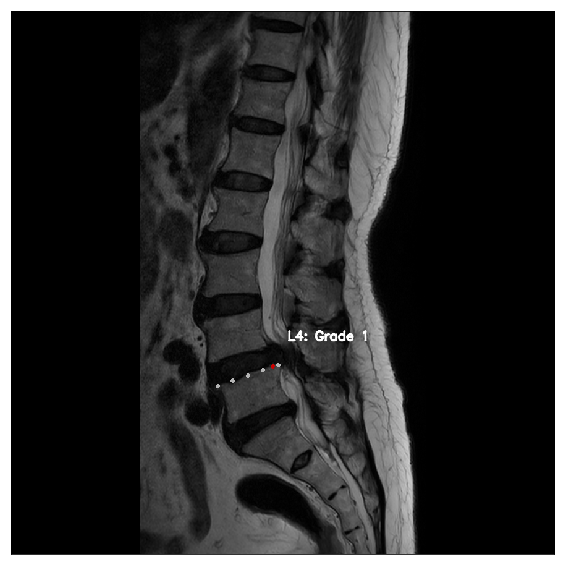

In [13]:

#滑脱等级
DIAGNOSIS = {4:'Grade 1', 3:'Grade 2',2:'Grade 3',1:'Grade 4',0:'Grade 0'}

#椎体类别
KIND = {1:'S1',2:'L5',3:'L4',4:'L3',5:'L2',6:'L1'}
params = 'output2/best_model/model.pdparams'
model = SFNet(
    num_classes=20, 
    backbone=ResNet50_vd(output_stride=8),
    backbone_indices=[0, 1, 2, 3],
)

img_path = '/home/aistudio/test/98.png'

origin = cv2.imread(img_path)
# 模型推理并还原大小
mask = cv2.resize(nn_infer(model, img_path, params), (origin.shape[1], origin.shape[0]), cv2.INTER_NEAREST)

lowerCentrum = {'box':[], 'result':[]}  #用来存储下位椎体的4个顶角和4等份坐标
upperCentrum = {'box':[], 'result':[]}  #用来存储上位椎体的4个顶角和4等份坐标
#循环骶骨1和腰5椎体
for kind in range(1,7):
    centrum = mask.copy()
    centrum[centrum!=kind]=0
    points = list()
    ret, threshold = cv2.threshold(centrum, 0,255, cv2.THRESH_BINARY)
    threshold = threshold.astype(np.uint8)
    #获取椎体轮廓
    contours, hierarch = cv2.findContours(threshold, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    #只保留最大的面积的轮廓
    contours.sort(key=cnt_area, reverse=True)
    if len(contours) > 1:
        for i in range(1,len(contours)):
            cv2.drawContours(threshold, [contours[i]], 0, 0, -1)

    #找到轮廓凸包并进行填充
    hull = cv2.convexHull(contours[0])
    cv2.drawContours(threshold, [hull], 0, 255, -1)

    #重新找到轮廓
    contours, hierarch = cv2.findContours(threshold, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    # 对轮廓多边形逼近
    epsilon = 0.01 * cv2.arcLength(contours[0], True)
    approx = cv2.approxPolyDP(contours[0], epsilon, True)
    
    #得到轮廓的旋转框
    rect = cv2.minAreaRect(contours[0])
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    box = box.tolist()
    
    #从外界旋转框中得到矩形框的四个角的坐标，上面得到逼近多边形的所有坐标
    #先假设旋转框的四个角的顺序是box[0]:左下角，box[1]：左上角，2：右上角，3：右下角。
    #然后循环这个四个角，每个角都与逼近多边形的坐标进行距离计算(为了找到离这个角最近的坐标。)
    #距离进行排序，最小的就是距离最近的。就是所确定的椎间盘的四个顶角的坐标
    for index, b in enumerate(box):
        p = list()
        for point in approx:
            point = np.array(point[0])
            distance = np.linalg.norm(point-b)
            p.append((point.tolist(),distance))
        p.sort(key=takeSecond,reverse = False)
        box[index] = p[0][0]

    #也分两种情况，情况一椎体逆时针有一定角度或者是骶骨1
    if box[0][0] < box[2][0] or kind == 1:
        leftBottom = box[0]
        leftTop = box[1]
        rightTop = box[2]
        rightBottom = box[3]
    else:#情况二椎体顺时针有一定角度
        rightBottom = box[0]
        leftBottom = box[1]
        leftTop = box[2]
        rightTop = box[3]
    #以上的轮廓查找，凸包，多边形逼近，旋转矩形框，等操作
    #都是为了找到椎体的左上角、右上角、右下角、左下角。
    
    #对椎体的左上角和右上角连接的直线进行四等分，得到5个坐标。
    #这个5个坐标就是用来判断上位椎体与下位椎体的滑脱情况。
    result = calcX(rightTop, leftTop)

    #假如遇到骶骨就跳出这次循环
    if kind ==1:
        lowerCentrum['box'] = [leftTop, rightTop,rightBottom, leftBottom]
        lowerCentrum['result'] = result
        continue
    
    #存储上位椎体的4个顶角和4等份坐标
    upperCentrum['box'] = [leftTop, rightTop,rightBottom, leftBottom]
    upperCentrum['result'] = result

    #计算上位椎体的右下角在下位椎体的左上角右上角直线上的垂足坐标。
    intersection = calcIntersection(lowerCentrum['result'][0],lowerCentrum['result'][4],upperCentrum['box'][2])

    #根据垂足坐标中y值与下位椎体的左上角和右上角连接的直线4等分的5个坐标的y值进行比较。
    #根据垂足坐标中的y值在列表中的位置就可以判断滑脱等级。
    result_temp = lowerCentrum['result']
    box_temp = lowerCentrum['box']
    result_temp.append(intersection)
    result_temp.sort(key=takeFirst,reverse = False)
    index = result_temp.index(intersection)
    
    if index < 5 and index !=0:
        #在原图上绘制下位椎体四等分，用点表示
        for point in lowerCentrum['result']:
            cv2.circle(origin,tuple(point),2, (180,180,180), 2)
        cv2.circle(origin,tuple(intersection),2, (200,0,0), 2)
        cv2.putText(origin,"{}".format(KIND[kind] + ': '+DIAGNOSIS[index]), (box_temp[1][0]+15,box_temp[1][1]-40), cv2.FONT_HERSHEY_SIMPLEX, 0.7,(255,255,255), 2, cv2.LINE_AA)
        
    lowerCentrum = upperCentrum.copy()
plt.figure(figsize=(10,10))
plt.imshow(origin)
plt.xticks([])
plt.yticks([])
plt.show()

### 结果展示
![](https://ai-studio-static-online.cdn.bcebos.com/004d6a80d1e645f9aa29056041a2bbb5b994ddadd7494bd58e753a89b7af3e0b)



### 总结
整个项目是基于分割+传统方式来完成，从效果来看，基本能符合诊断要求。但是分级的效果的好坏由分割效果来决定。而且这个数据没有4级和3级滑脱情况。模型遇到4级数据，不一定可以很好的分割出来。所有在实际使用情况下，需要增加这一类数据重新在训练一个泛化能力强的模型。